In [25]:
# IMPORTS

#pip3 install -r requirements
from train import *

# Intructions

Both training and evaluation are done inside the Chef() object instance. All of the hyperparameters can be modified in the config.ini file, the argument parser takes care of the rest.

### Downloading and Preprocessig Data

Initially this will take some time. You are going to be left with the original wfdb format files from the MIT-BIH dataset, as well as with cleaned/preprocessed csv files, which will ultimately be used for training and evaluation of the model. You only need the preprocessed files, so you can delete the original folder 'mit-bih-arrhythmia-database-1.0.0' after the preprocessor finishes. Alternatively you can set the wipe_original argument in data.preprocessor() to true and it will do that for you. Process took us 20 minutes to complete.

### Training the Model

Set the number of training iterations in config.ini EPOCHS parameter. You can also modify the BATCH_SIZE and MODEL_SAVE_NAME, but you should keep other hyperparameters as they are. Run the train.py script, which trains the model and the decoder and saves their state dicts into the /models folder.

### Evaluating the Model

Repo contains an already trained model and decoder instances, named JIMMY inside the models/ folder. Chef's .inject() method is used to return the model and decoder instance from the previous stored models for further use. You can change the Gordon.inject('JIMMY') to the name of your own trained model in the Evaluation cell bellow, run it and get the evaluation metrics for your trained model. 

# Visualizing Data

If we make a pie chart for the distribution of the 5 classes, we notice they are distributed quite unevenly.
We are going to take this into account when we compute evaluation metrics, since accuracy alone can be deceptive 
in this case. If the percentage of the dominant class 0 is around 85%, then a model that always predicts class 0
can seem quite good from that metric alone, which is obviously not the case.

MIT-BIH folder already exists at: mit-bih-arrhythmia-database-1.0.0
Forming Labeled Data Pairs ...


100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


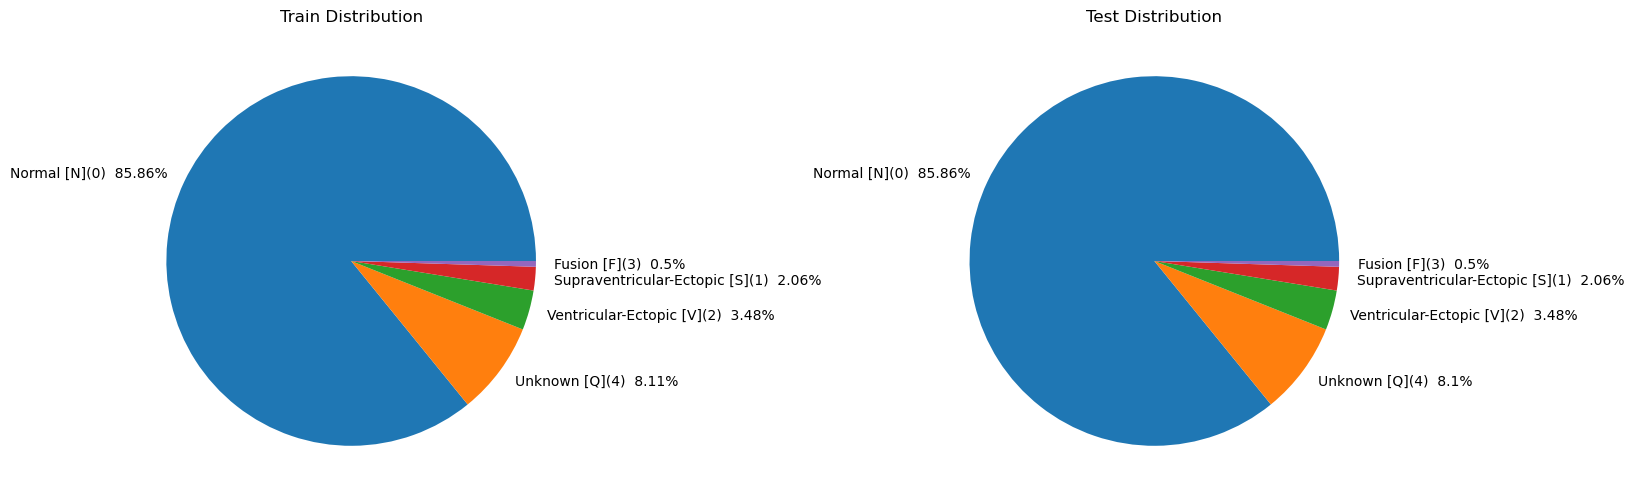

In [24]:
# Ensure that distributions of train and test dataset classes are the same
from collections import Counter

train_dataset, test_dataset, TRAINLOADER, TESTLOADER = get_data()

train_labels, train_counts = zip(*sorted(Counter(train_dataset.labels).items(), key=lambda x:-x[1]))
test_labels, test_counts = zip(*sorted(Counter(test_dataset.labels).items(), key=lambda x:-x[1]))
train_percentages = [round(100*train_counts[i]/sum(train_counts), 2) for i in range(5)]
test_percentages = [round(100*test_counts[i]/sum(test_counts), 2) for i in range(5)]

int_to_label = dict(zip(range(5), ['Normal [N](0)', 'Supraventricular-Ectopic [S](1)', 'Ventricular-Ectopic [V](2)', 'Fusion [F](3)', 'Unknown [Q](4)']))

# Pie Charts
fig, ax = plt.subplots(1,2, figsize=(19,6))

ax[0].pie(train_counts, labels=[int_to_label[i] + f'  {train_percentages[j]}%' for j,i in enumerate(train_labels)])
ax[0].set_title('Train Distribution')
ax[1].pie(test_counts, labels=[int_to_label[i] + f'  {test_percentages[j]}%' for j,i in enumerate(test_labels)])
ax[1].set_title('Test Distribution');

Let's select 5 samples from each class and plot them, to get a rough idea of what they look like.

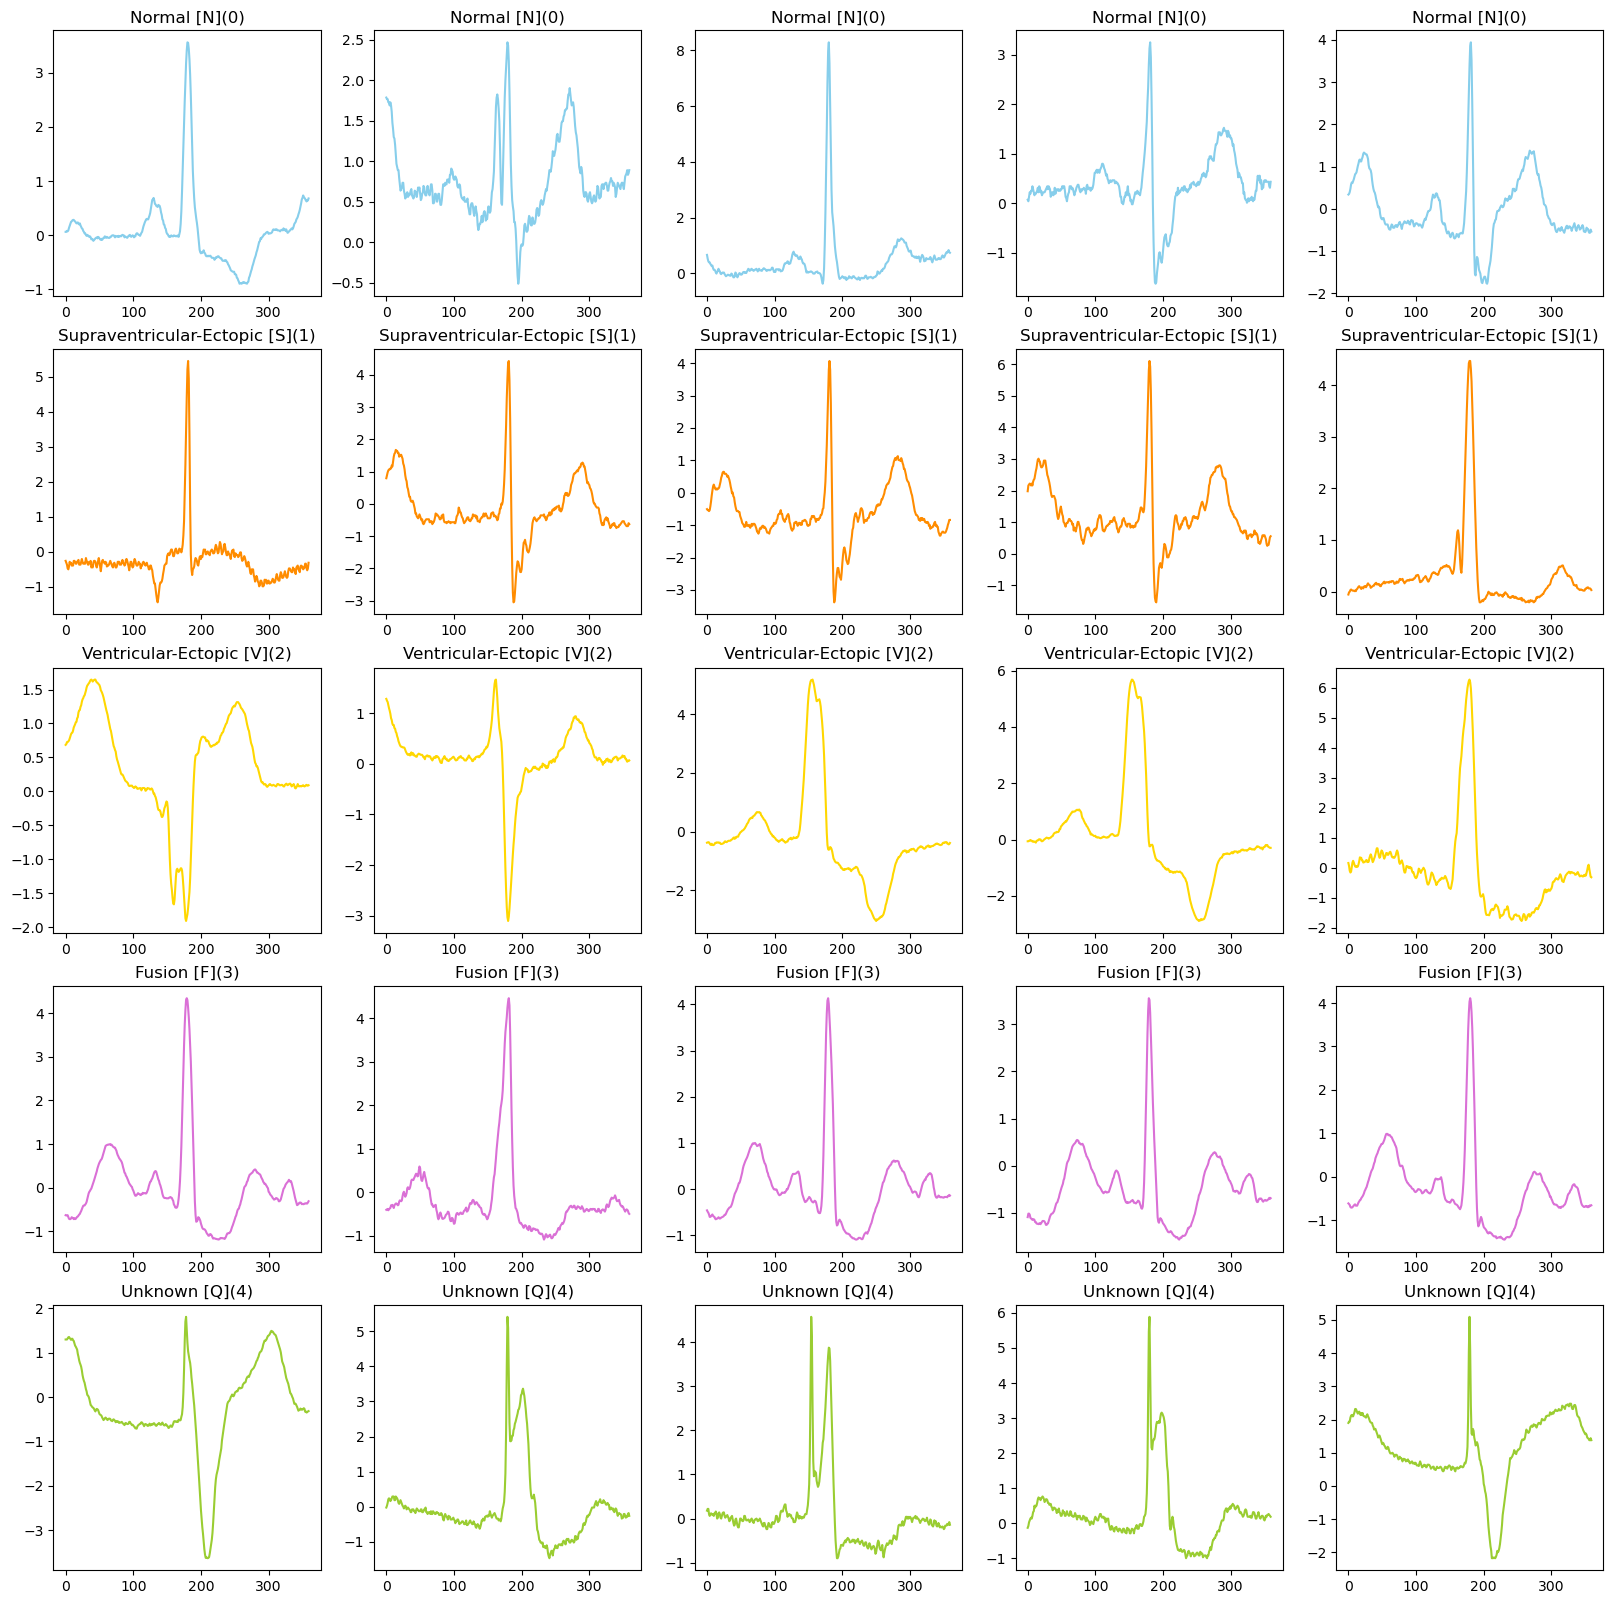

In [3]:
# Display samples of all classes

# plots of class instances
from collections import defaultdict
import random

pairs = [(sample, label) for sample, label in zip(train_dataset.data, train_dataset.labels)] + \
        [(sample, label) for sample, label in zip(test_dataset.data, test_dataset.labels)]
random.shuffle(pairs)


plot_colors = ['skyblue', 'darkorange', 'gold', 'orchid', 'yellowgreen']
int_to_color = dict(zip(range(5), plot_colors))
train_reps = {k:[] for k in int_to_label}

def check_if_full(d):
    for key, item in d.items():
        if len(item) < 5:
            return False
    return True

for sig, label in pairs:
    L = int_to_label[label]
    if len(train_reps[label]) < 5:
        train_reps[label].append(sig)

    if check_if_full(train_reps):
        break
        

fig, axes = plt.subplots(5,5, figsize=(20,20))

for i,k in enumerate(train_reps):
    for j, sig in enumerate(train_reps[k]):
        sig = sig.squeeze(0)
        axes[i,j].plot(sig, color=int_to_color[k])
        axes[i,j].set_title(f'{int_to_label[i]}')

# Evaluation Metrics

As expected the model seems to struggle the most with classes 1 and 3, which are the scarcest in the dataset.

100%|██████████| 303/303 [01:07<00:00,  4.46it/s]


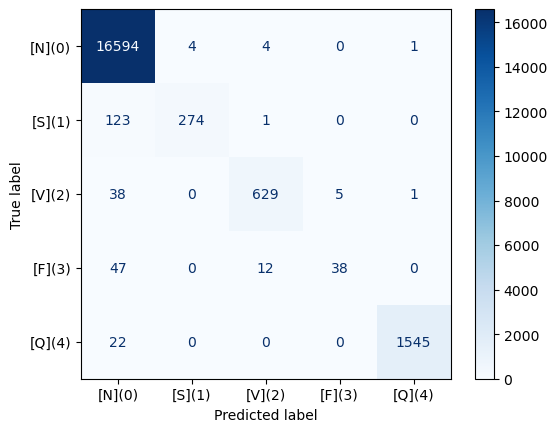

,Class,Accuracy
0,Normal [N](0),0.999458
1,Supraventricular-Ectopic [S](1),0.688442
2,Ventricular-Ectopic [V](2),0.934621
3,Fusion [F](3),0.391753
4,Unknown [Q](4),0.985960
5,TOTAL,0.986658


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Gordon = Chef(batch_size=BATCH_SIZE, model=MODEL, decoder=DECODER,
              trainloader=TRAINLOADER, testloader=TESTLOADER)

Gordon.inject('JIMMY')
y_true, y_preds = Gordon.taste()

class_accuracies = []
accuracy = accuracy_score(y_true, y_preds)
cm = confusion_matrix(y_true, y_preds)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[n[-6:] for n in list(int_to_label.values())])
disp.plot(cmap=plt.cm.Blues)
plt.show()

for cls, acc in enumerate(per_class_accuracy):
    class_accuracies.append((int_to_label[cls], acc))
    #print(f'Accuracy of {int_to_label[cls]:<50}  {round(acc, 5):>10}')
class_accuracies.append(('TOTAL', accuracy))

pd.DataFrame(class_accuracies, columns=['Class', 'Accuracy'])

# Reconstructions

TimeCaps models are regularized by reconstruction of input data. This means that after we are done training the classifier, we also have a trained decoder. Let's see what do the reconstructions of the decoder look like, compared to original inputs.

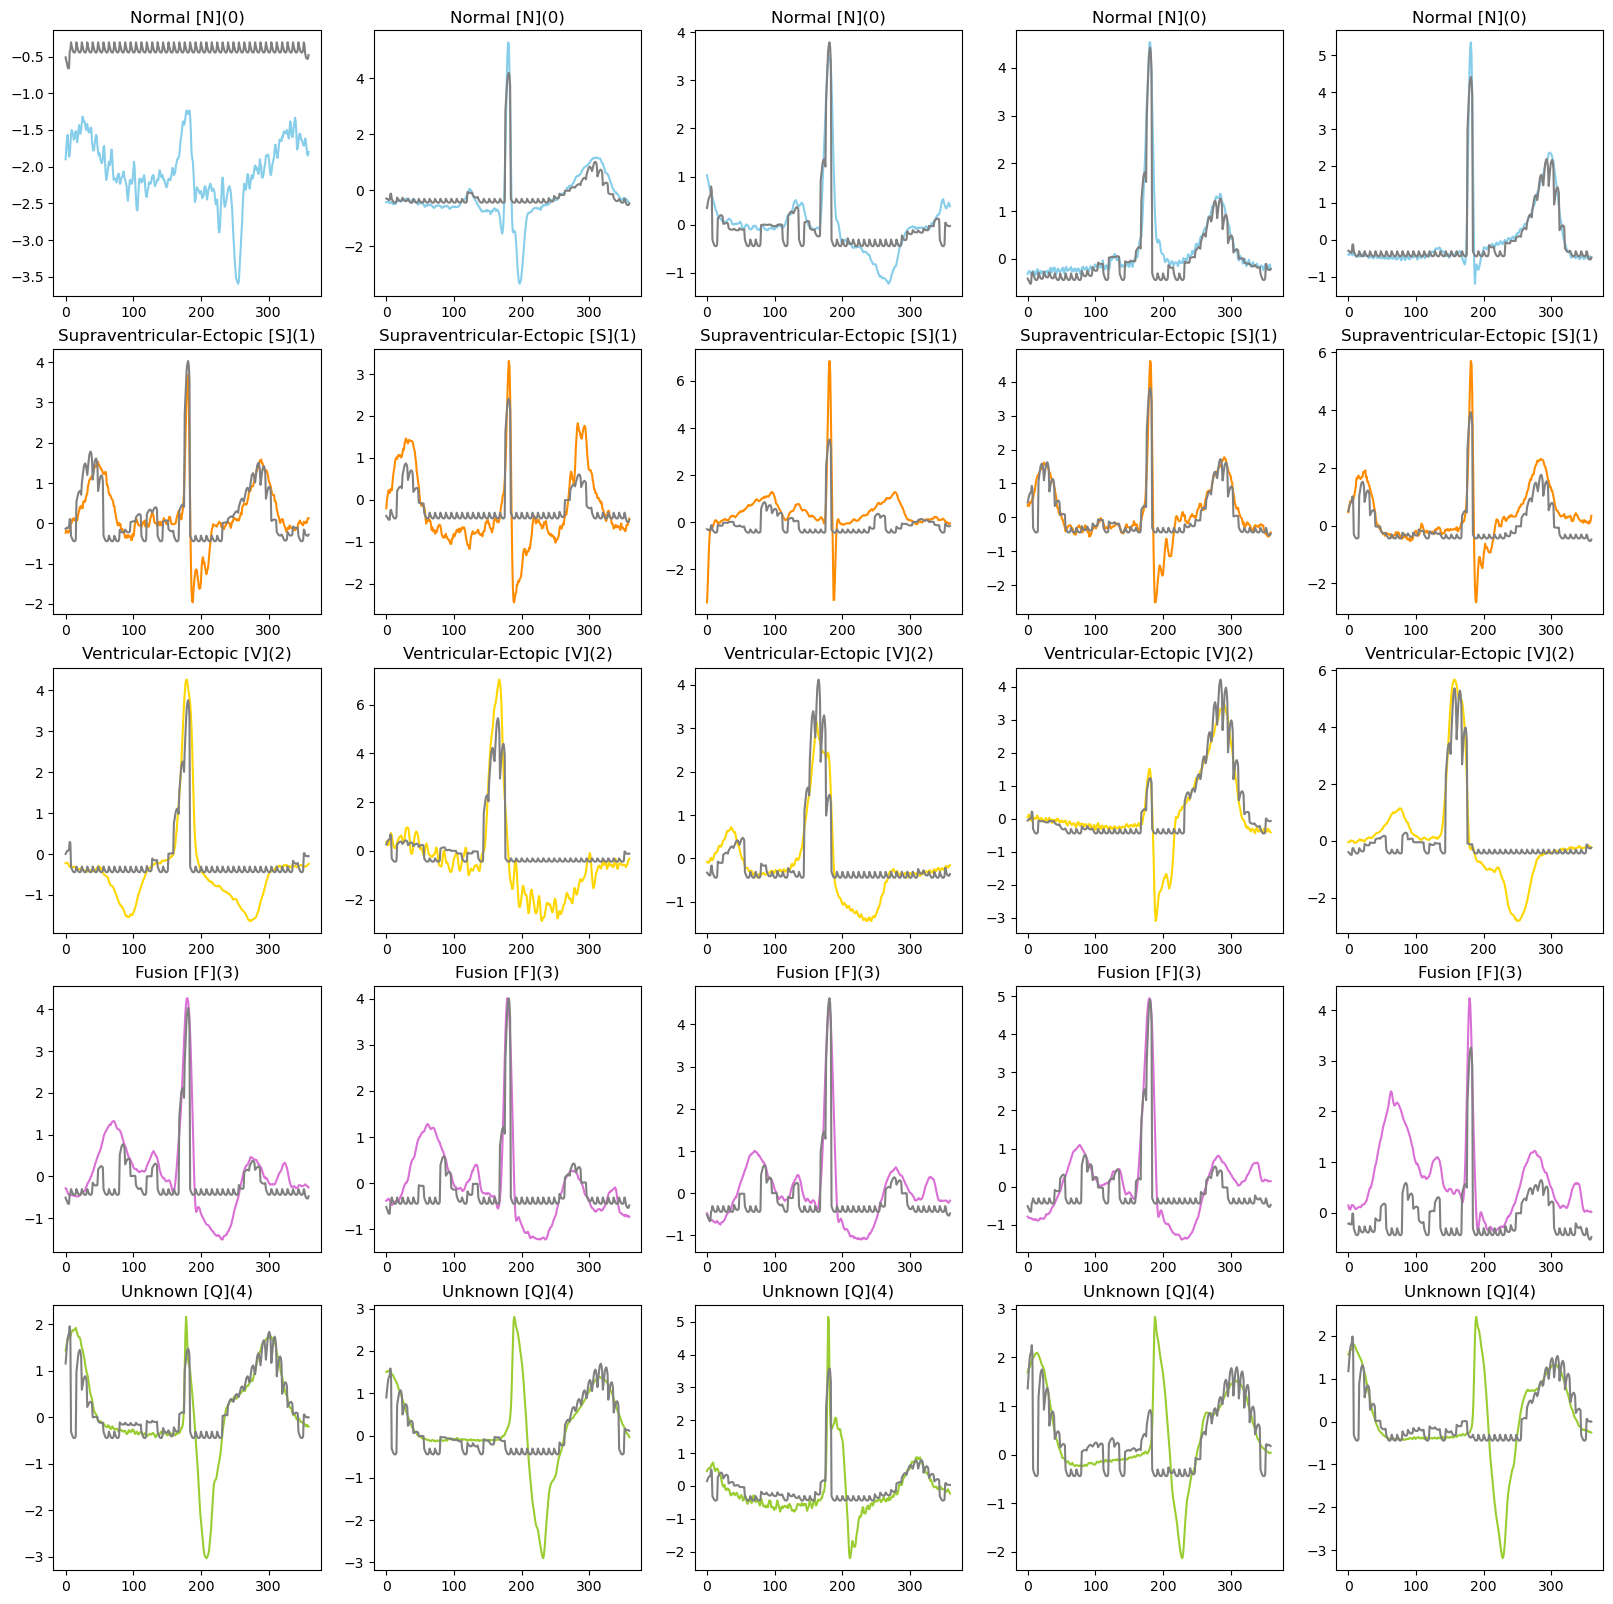

In [9]:
# Reconstructions

# Display samples of all classes

# plots of class instances
from collections import defaultdict
import random
test_pairs = [(sample, label) for sample, label in zip(test_dataset.data, test_dataset.labels)] 
random.shuffle(test_pairs)

label_to_int = {l:i for i,l in int_to_label.items()}
plot_colors = ['skyblue', 'darkorange', 'gold', 'orchid', 'yellowgreen']
reconstruction_color = 'grey'
label_to_color = {l:c for l,c in zip(label_to_int.keys(), plot_colors)}
test_reps = {k:[] for k in label_to_int}
test_caps = {k:[] for k in label_to_int}
test_reconstructions = {k:[] for k in label_to_int}


model, decoder = Gordon.model, Gordon.decoder
model.to(DEVICE)
decoder.to(DEVICE)
model.eval()
decoder.eval()

for sig, label in test_pairs:
    sig = sig.unsqueeze(0).to(DEVICE)
    L = int_to_label[label]
    if len(test_reps[L]) < 5:
        test_reps[L].append(sig[:].squeeze(0,1).to('cpu'))
        out = model(sig)
        reconstruction_cap = out[:,label,:]
        test_caps[L].append(reconstruction_cap[:].squeeze(0).to('cpu').detach())
        reconstruction = decoder(reconstruction_cap)
        test_reconstructions[L].append(reconstruction[:].squeeze(0).to('cpu').detach())

    if check_if_full(test_reps):
        break


fig, axes = plt.subplots(5,5, figsize=(20,20))

for i,k in enumerate(test_reps):
    for j, sig in enumerate(test_reps[k]):
        reconstruction = test_reconstructions[k][j]

        axes[i,j].plot(sig, color=label_to_color[k])
        axes[i,j].plot(reconstruction, color=reconstruction_color)
        axes[i,j].set_title(f'{int_to_label[i]}')

# Interpreting Instantiation Parameters

As per original capsule networks paper for 2d data: [Dynamic Routing Between Capsules](https://arxiv.org/pdf/1710.09829), we can tweak each instantiation parameters in some range, send the tweaked capsule through the decoder and compare it to the original reconstruction.
This makes TimeCaps somewhat interpretable.

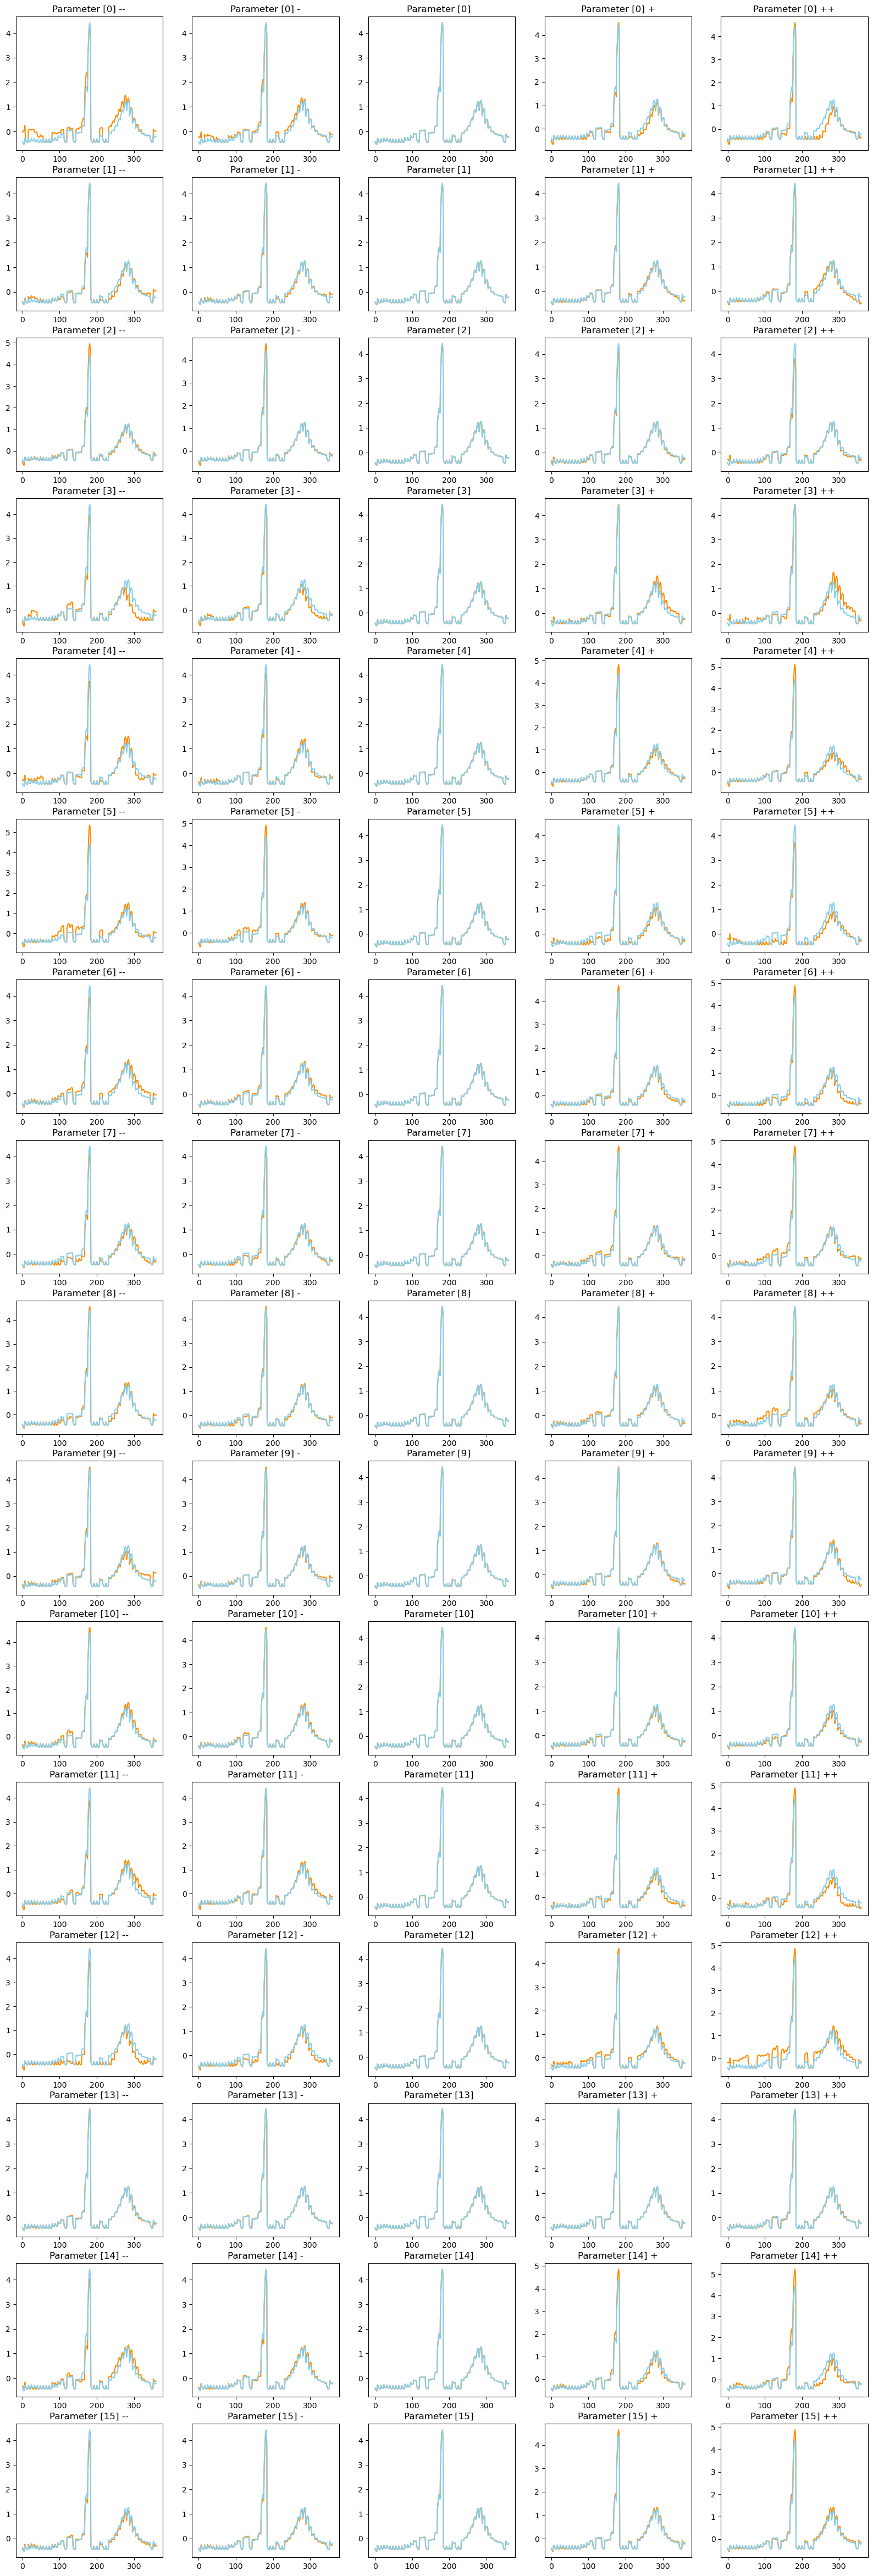

In [12]:
cap = test_caps['Normal [N](0)'][3] 

signs = ['--', '-', ' ', '+', '++']
lookup = dict(zip(range(5), signs))

unbined = [i.item() for i in torch.unbind(cap.clone().detach())]
intervals = []

decoder = Gordon.decoder.to('cpu')
decoder.eval()

for param in unbined:
    baseline = abs(param)
    interval = torch.linspace(param - 0.5*baseline, param + 0.5*baseline, 5)
    intervals.append(interval)

fig, axes = plt.subplots(16,5, figsize=(20,60))

baseline_reconstruction = decoder(cap.unsqueeze(0)).detach()

for i, interval in enumerate(intervals):
    for j, param in enumerate(interval):
        cap_mod = cap.clone().unsqueeze(0)
        cap_mod[:,i] = param
        reconstruction = decoder(cap_mod)

        axes[i,j].plot(reconstruction.squeeze(0).detach(), color='darkorange')
        axes[i,j].plot(baseline_reconstruction.squeeze(0).detach(), color='skyblue')
        sign = lookup[j]
        axes[i,j].set_title(f'Parameter [{i}] {sign}')